## Take home assignment - NC

This notebook contains the assignment for Natural Cycles take home assignment. The notebook is organized as follows: (a) exploratory data analysis (b) data proprocessing (c) univariate time to event modeling (d) basic ML classifier (d) SHAP



- Author: Skanda Muralidhar
- Date: 22 June 2025




In [3]:
## --- Import needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
import shap

from lifelines import KaplanMeierFitter, statistics,CoxPHFitter
from lifelines.utils import median_survival_times

%matplotlib inline
import matplotlib.pyplot as plt

## Set Seaborn Theme
sns.set_theme()

## Set Color Palette for plots
# Create a custom palette using HEX codes 
#hex = sns.color_palette(["#FF6B6B", "#4ECDC4", "#45B7D1","#FAD02E", "#594F4F"])
sns.set_palette("rocket")

# 1. Read dataset and inspect columns

In [4]:
## --- Read Data File
raw_data_df = pd.read_csv("~/Downloads/Natural_Cycles/ncdatachallenge-2021-v1.csv")
raw_data_df.head()

,Unnamed: 0,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,0,22.942130,31,SE,"No, never",University,Wake same every workday,1,pregnant,0.640000,25.588235,2.526332,True,0.200000
1,1,19.886054,34,NaN,NaN,University,NaN,7,pregnant,0.009569,30.875000,3.522884,True,0.052632
2,2,29.323049,41,SE,"No, never",University,Several times during the night,4,not_pregnant,0.298246,27.666667,2.503331,True,0.149123
3,3,24.386526,27,SE,"No, never",High school,Wake same every workday,2,pregnant,0.895833,24.250000,3.453776,True,0.145833
4,4,29.299971,29,SE,"No, never",Trade/technical/vocational training,Wake same every day,2,pregnant,0.666667,25.466667,0.990430,True,0.254902


# 2. Exploratory Data Analysis

In [5]:
raw_data_df.drop(columns=['Unnamed: 0'], inplace=True)
raw_data_df.describe()

,bmi,age,n_cycles_trying,dedication,average_cycle_length,cycle_length_std,intercourse_frequency
count,1995.000000,1995.000000,1995.000000,1995.000000,1989.000000,1970.000000,1995.000000
mean,23.357643,31.898747,4.725815,0.475641,30.530185,4.465253,0.106986
std,4.982275,4.063534,4.600871,0.335528,7.010407,8.675280,0.105248
min,0.000000,19.000000,1.000000,0.000000,19.500000,0.000000,0.000000
25%,20.708276,29.000000,1.000000,0.132567,27.176471,1.718249,0.020000
50%,22.530864,32.000000,3.000000,0.505415,29.000000,2.542727,0.080214
75%,25.303154,35.000000,6.000000,0.780816,31.666667,4.272002,0.162195
max,50.611299,44.000000,26.000000,1.347826,145.500000,168.998521,0.793103


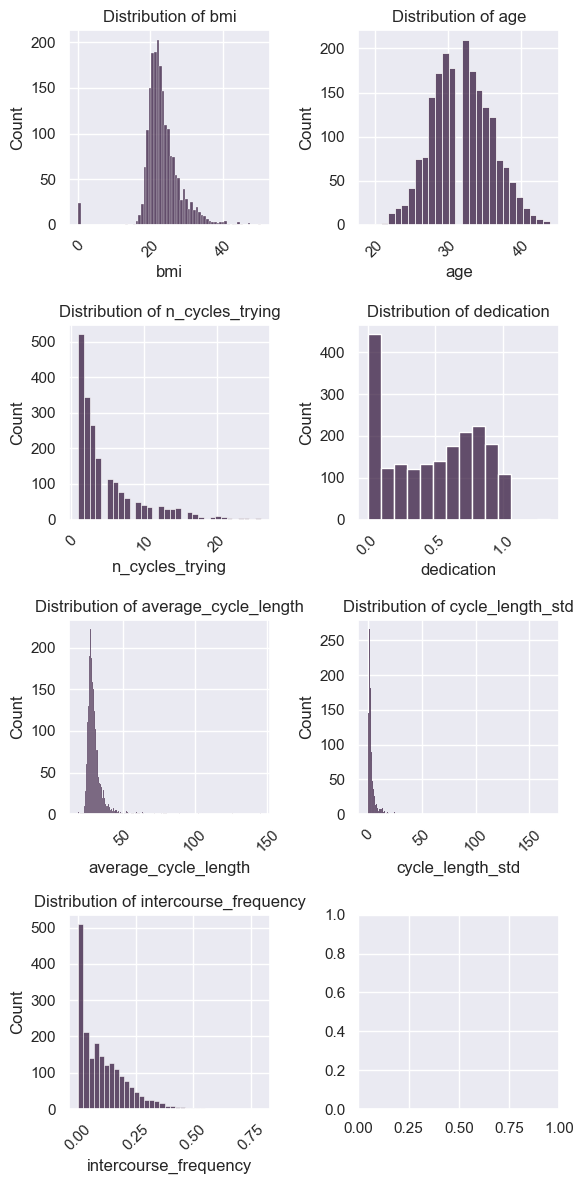

In [60]:
## visualize non-numeric columns
raw_data_numerical_df = raw_data_df.select_dtypes(include= np.number)
fig , axs = plt.subplots(4,2,figsize = (6,12))     # set up 2 x 2 frame count plot with figsize 10 x 10
for col , subplots in zip (raw_data_numerical_df, axs.flatten()):
        sns.histplot(data=raw_data_numerical_df, x=raw_data_numerical_df[col], ax=subplots)
        subplots.set_title(f'Distribution of {col}')
        subplots.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


### Observations:
- mean age of women in the given data is ~32 years with the youngest being 19 and oldest being 44 years.
- mean BMI is ~23 with range from ~20 to ~50. There are BMI values of 0 indicating either data is missing or corrupted. This data will needed to handled in consultation with domain experts.
- mean intercourse frequency is about 10% with max of 80%
- mean number cycles tried is 4.75 with max of 26 and min of 1
- avg cycle length is 30 days

In [ ]:
#display(raw_data_df[raw_data_df['bmi'] == 0])
#display(raw_data_df[raw_data_df['intercourse_frequency'] == 0])

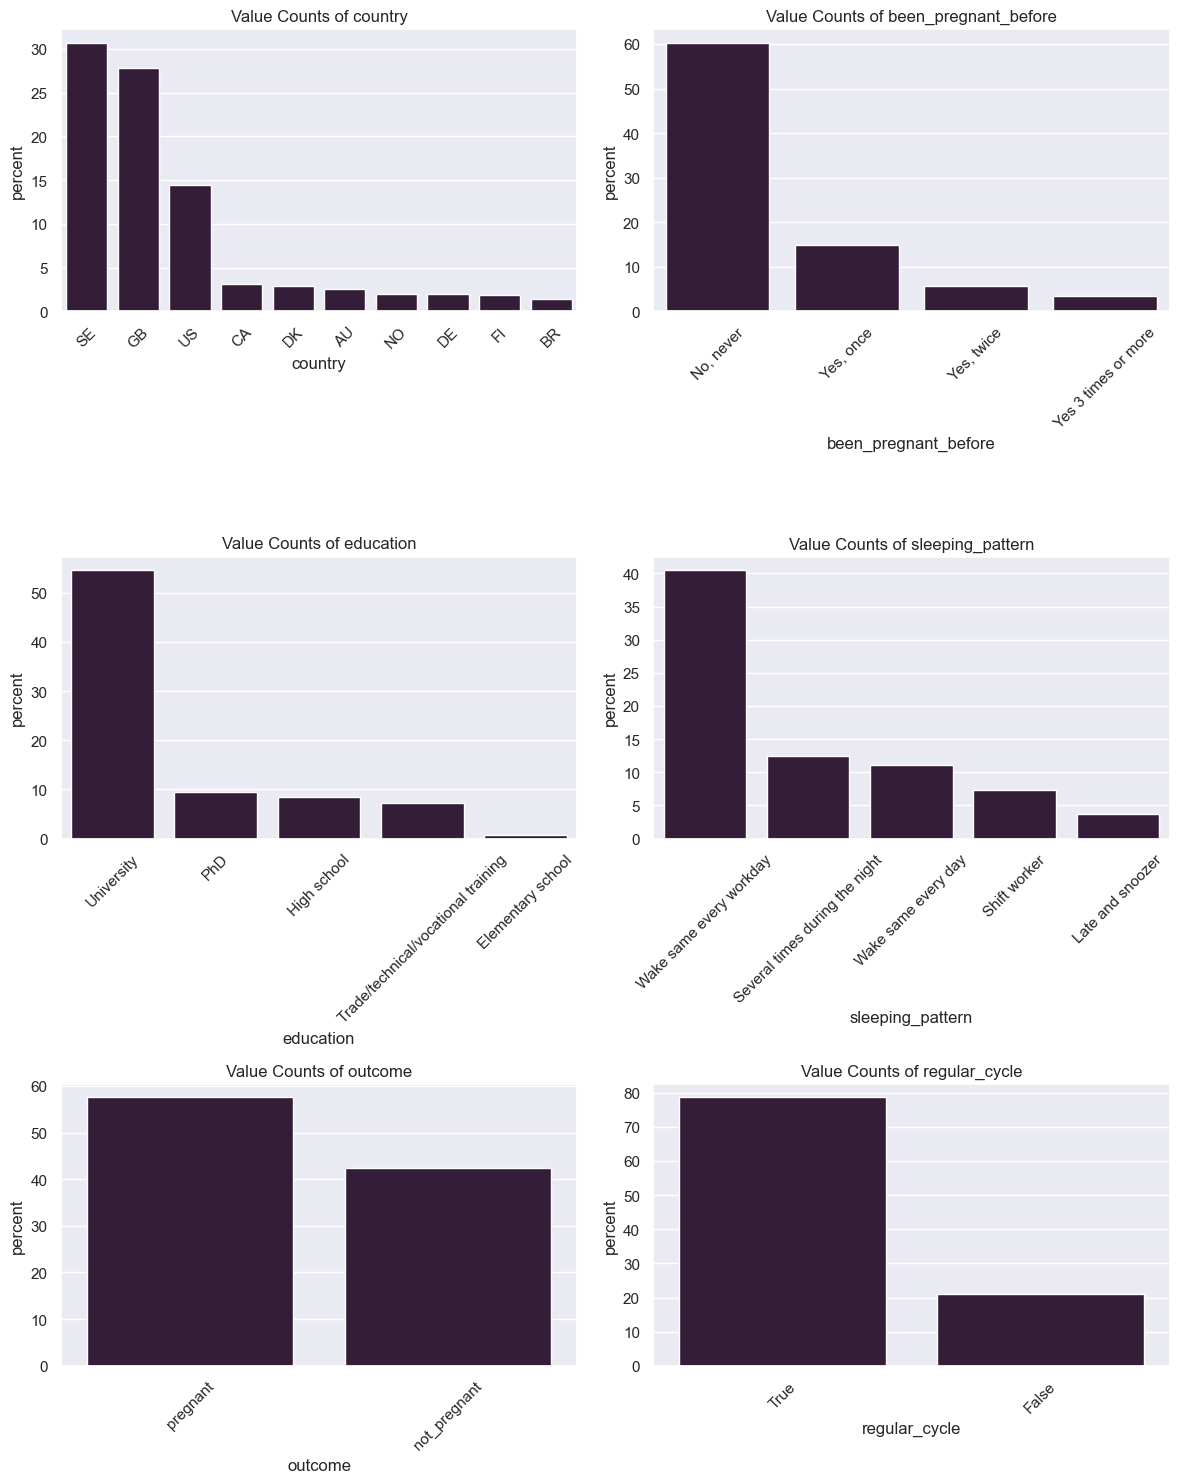

In [6]:
## visualize non-numeric columns
raw_data_categorical_df = raw_data_df.select_dtypes(exclude= np.number)
fig , axs = plt.subplots(3,2,figsize = (12,15))     # set up 2 x 2 frame count plot with figsize 10 x 10
for col , subplots in zip (raw_data_categorical_df, axs.flatten()):
        sns.countplot(data=raw_data_categorical_df, x=raw_data_categorical_df[col],order=raw_data_categorical_df[col].value_counts().iloc[:10].index, stat="percent", ax=subplots)
        subplots.set_title(f'Value Counts of {col}')
        subplots.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


### Observations:
This visualization gives an insight into the demographics of the participants in the dataset.
- most of the data (~70%) comes from 3 countries (Sweden, Britain and US). 
- Majority of the women (~60%) are first time expectant moms.
- More than half of the women have a University education, and were pregnant after n_cycles. 
- majority (~80%) have regular cycles.

NOTE: Y-axis is converted to percentage


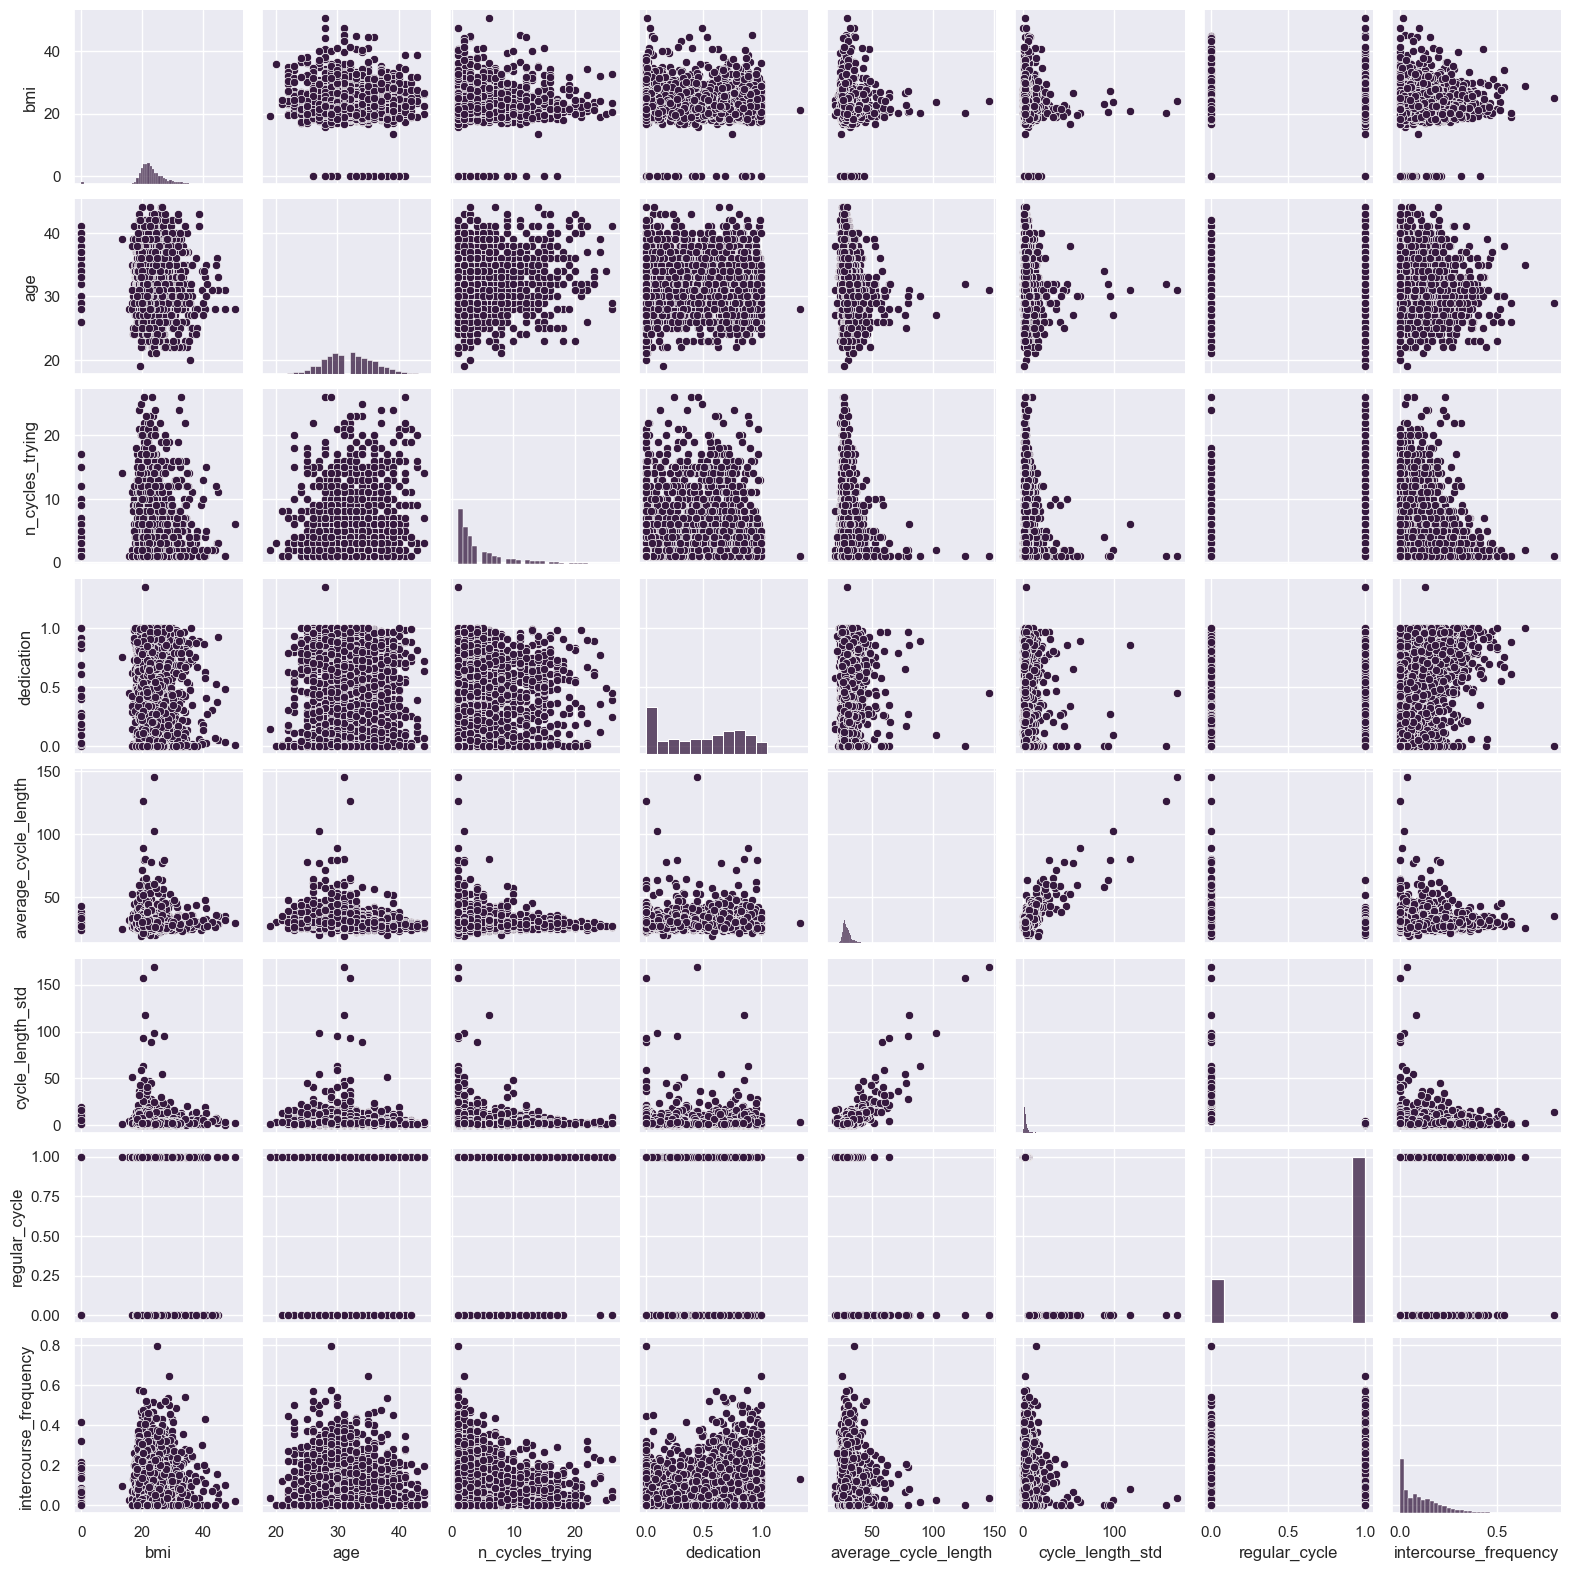

In [7]:
cols=['bmi','age','country','been_pregnant_before',	'education','sleeping_pattern', 'n_cycles_trying',
      'outcome','dedication','average_cycle_length','cycle_length_std', 'regular_cycle', 'intercourse_frequency']
sns.pairplot(raw_data_df[cols], height=2.0)

# 3. Feature Engineering

In this section, we do some basic feature engineering like data imputation and conversion from categorical variable into numerical

In [8]:
print("Raw data shape", raw_data_df.shape)
print("Shape after dropping NaNs", raw_data_df.dropna().shape)

Raw data shape (1995, 13)
Shape after dropping NaNs (1185, 13)


In [9]:
## Identify columns with most NaNs
raw_data_df.isnull().sum().sort_values(ascending=False)

sleeping_pattern         499
education                391
been_pregnant_before     317
country                  113
cycle_length_std          25
average_cycle_length       6
regular_cycle              6
bmi                        0
age                        0
n_cycles_trying            0
outcome                    0
dedication                 0
intercourse_frequency      0
dtype: int64

### Observations:
We observe that we will loose about 40% of data if we blindly drop NaNs. Instead, we dig a little more to see if we can impute any missing data.
- some variables like *country* and *education* can imputed with their most common values, 
- while variable of importance like *sleeping_pattern* and *pregnant_before* we can replace NaNs by *Unkown* giving us more data points for analysis.
- NOTE: Its always a good idea to discuss with domain experts about how best to deal with missing data.


In [10]:
data_df = raw_data_df.copy() ##  Make a copy
data_df['country'] = data_df['country'].fillna(data_df['country'].mode().iloc[0])
data_df['education'] = data_df['education'].fillna(data_df['education'].mode().iloc[0])
data_df[['been_pregnant_before', 'sleeping_pattern']] = data_df[['been_pregnant_before','sleeping_pattern']].fillna("Unknown")

## We drop the numerical columns that have NaN
data_df.dropna(inplace=True)


In [11]:
# For categorical features, the input preprocessed and encoded using sklearn
ord_enc = OrdinalEncoder()
data_df["been_pregnant_before"] = ord_enc.fit_transform(data_df[["been_pregnant_before"]])
data_df["country"] = ord_enc.fit_transform(data_df[["country"]])
data_df["education"] = ord_enc.fit_transform(data_df[["education"]])
data_df["sleeping_pattern"] = ord_enc.fit_transform(data_df[["sleeping_pattern"]])
data_df['outcome'] = ord_enc.fit_transform(data_df[['outcome']])

## Convert True/False into 1 and 0
data_df['regular_cycle'] = data_df['regular_cycle'].astype(int)


In [12]:
data_df.head()

,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,22.942130,31,30.0,0.0,4.0,5.0,1,1.0,0.640000,25.588235,2.526332,1,0.200000
1,19.886054,34,30.0,1.0,4.0,3.0,7,1.0,0.009569,30.875000,3.522884,1,0.052632
2,29.323049,41,30.0,0.0,4.0,1.0,4,0.0,0.298246,27.666667,2.503331,1,0.149123
3,24.386526,27,30.0,0.0,1.0,5.0,2,1.0,0.895833,24.250000,3.453776,1,0.145833
4,29.299971,29,30.0,0.0,3.0,4.0,2,1.0,0.666667,25.466667,0.990430,1,0.254902


# 4. Compute Time-to-Event using Kaplan-Meier
Kaplan-Meier is a common non-parametric method used to estimate time-to-event from data.
It gives us an unbiased estimate of the survival probability. 
Kaplan-Meier is a constant predictor: it always estimates the mean survival curve for all individual in the (training) dataset: the estimated survival curve does not depend on features values 


In [13]:
kmf = KaplanMeierFitter()
kmf.fit(data_df['n_cycles_trying'], data_df['outcome'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1970 total observations, 832 right-censored observations>

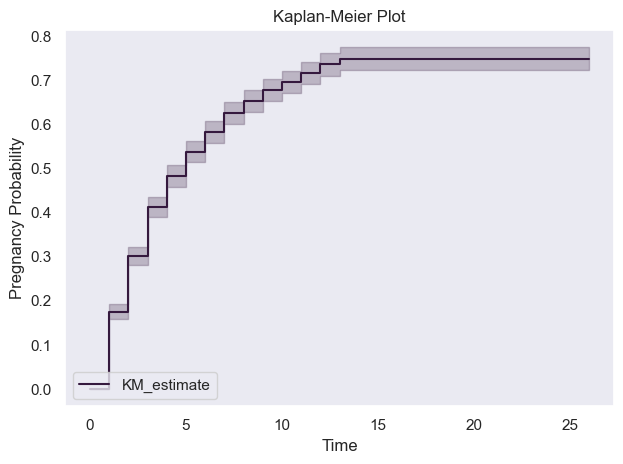

In [61]:
ax = kmf.plot_cumulative_density()
plt.title('Kaplan-Meier Plot')
plt.xlabel('Time')
plt.ylabel('Pregnancy Probability')
plt.grid(False)  # Add grid lines
plt.legend(loc='lower left')  # Show legend
plt.tight_layout()  # Adjust layout
plt.show()

In [17]:
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
median_ = kmf.median_survival_time_
print("Number of cycles it usually take to get pregnant:", median_)
print(median_confidence_interval_)
print("Probality of getting pregnant at 13 cycles:", kmf.cumulative_density_at_times(13))

Number of cycles it usually take to get pregnant: 5.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                     4.0                     5.0
Probality of getting pregnant at 13 cycles: 13    0.748632
Name: KM_estimate, dtype: float64


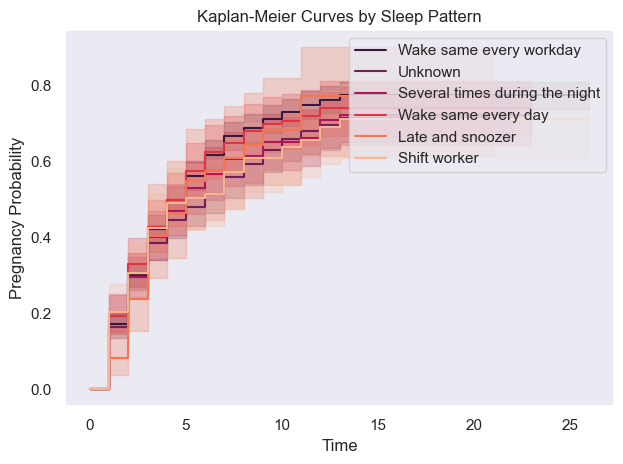

In [57]:
## Stratified Kaplan-Meier with sleep pattern, regular cycle, been_pregnant_before & education.
def plot_curve_by_sleep(df):
    sleep_pattern_unique = data_df["sleeping_pattern"].unique()
    fig_data = []
    for sleep in sleep_pattern_unique:
        data_df_brand = data_df.loc[data_df["sleeping_pattern"] == sleep]
        km = KaplanMeierFitter()
        km.fit(
            durations=data_df_brand["n_cycles_trying"],
            event_observed=data_df_brand["outcome"],
        )
        #km.plot(label=sleep)
        ax = km.plot_cumulative_density(label=sleep)

    plt.title('Kaplan-Meier Curves by Sleep Pattern')
    plt.xlabel('Time')
    plt.ylabel('Pregnancy Probability')
    plt.grid(False)  # Add grid lines
    plt.legend(loc='upper right')  # Show legend
    plt.tight_layout()  # Adjust layout
    plt.show()

    
plot_curve_by_sleep(data_df)

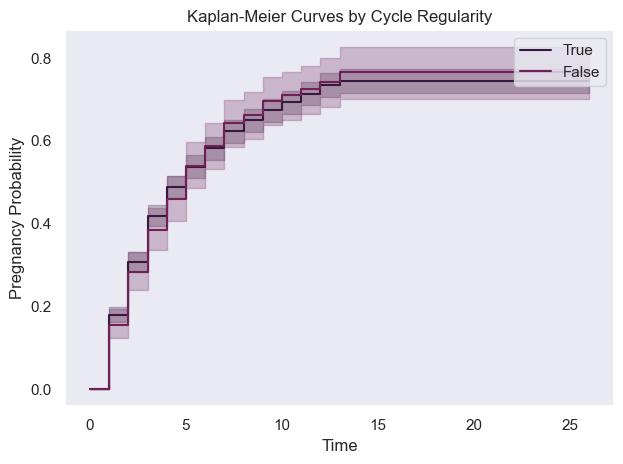

In [56]:
## Stratified Kaplan-Meier with sleep pattern, regular cycle, been_pregnant_before & education.
def plot_curve_by_cycle(df):
    cycle_pattern_unique = data_df["regular_cycle"].unique()
    fig_data = []
    for cycle in cycle_pattern_unique:
        data_df_cycle = data_df.loc[data_df["regular_cycle"] == cycle]
        km = KaplanMeierFitter()
        km.fit(
            durations=data_df_cycle["n_cycles_trying"],
            event_observed=data_df_cycle["outcome"],
        )
        #km.plot(label=cycle)
        ax = km.plot_cumulative_density(label=cycle)

    plt.title('Kaplan-Meier Curves by Cycle Regularity')
    plt.xlabel('Time')
    plt.ylabel('Pregnancy Probability')
    plt.grid(False)  # Add grid lines
    plt.legend(loc='upper right')  # Show legend
    plt.tight_layout()  # Adjust layout
    plt.show()

    
plot_curve_by_cycle(data_df)

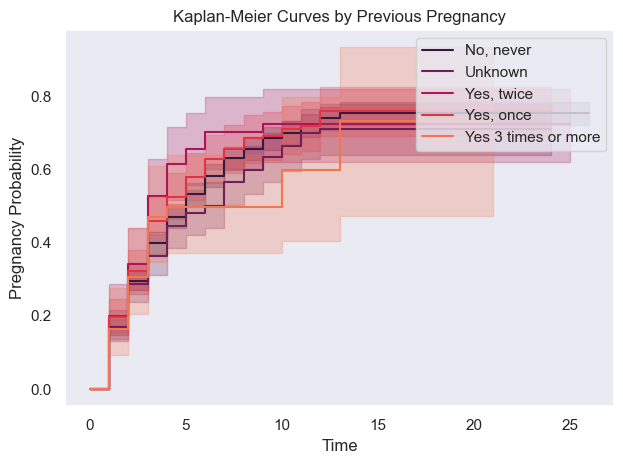

In [55]:
## Stratified Kaplan-Meier with sleep pattern, regular cycle, been_pregnant_before & education.
def plot_curve_by_pregant(df):
    pregnancy_pattern_unique = data_df["been_pregnant_before"].unique()
    fig_data = []
    for pregnant in pregnancy_pattern_unique:
        data_df_pregnant = data_df.loc[data_df["been_pregnant_before"] == pregnant]
        km = KaplanMeierFitter()
        km.fit(
            durations=data_df_pregnant["n_cycles_trying"],
            event_observed=data_df_pregnant["outcome"],
        )
        #km.plot(label=pregnant)
        ax = km.plot_cumulative_density(label=pregnant)

    plt.title('Kaplan-Meier Curves by Previous Pregnancy')
    plt.xlabel('Time')
    plt.ylabel('Pregnancy Probability')
    plt.grid(False)  # Add grid lines
    plt.legend(loc='upper right')  # Show legend
    plt.tight_layout()  # Adjust layout
    plt.show()

    
plot_curve_by_pregant(data_df)


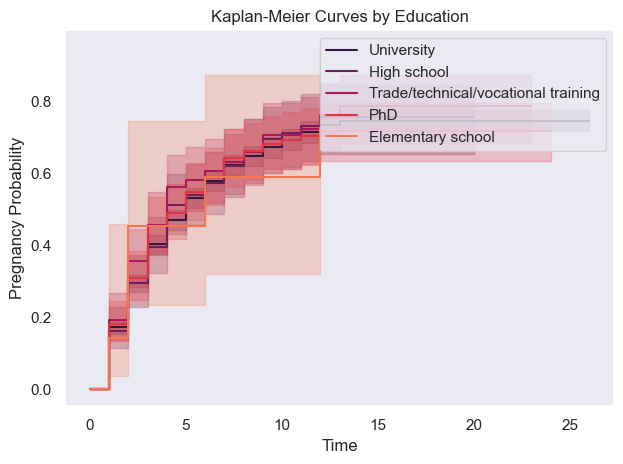

In [54]:
## Stratified Kaplan-Meier with sleep pattern, regular cycle, been_pregnant_before & education.
def plot_curve_by_education(df):
    education_pattern_unique = data_df["education"].unique()
    fig_data = []
    for education in education_pattern_unique:
        data_df_education = data_df.loc[data_df["education"] == education]
        km = KaplanMeierFitter()
        km.fit(
            durations=data_df_education["n_cycles_trying"],
            event_observed=data_df_education["outcome"],
        )
        #km.plot(label=education)
        ax = km.plot_cumulative_density(label=education)

    plt.title('Kaplan-Meier Curves by Education')
    plt.xlabel('Time')
    plt.ylabel('Pregnancy Probability')
    plt.grid(False)  # Add grid lines
    plt.legend(loc='upper right')  # Show legend
    plt.tight_layout()  # Adjust layout
    plt.show()

    
plot_curve_by_education(data_df)


In [ ]:
# Fit Cox model
"""
cph = CoxPHFitter()

## Get only numeric columns
data_df_numeric = data_df.select_dtypes(include= np.number)
cph.fit(data_df_numeric, duration_col='n_cycles_trying', event_col='outcome')
cph.print_summary()

# Predict survival probability for a sample
survival_function = cph.predict_survival_function(data_df_numeric.iloc[:5])
print(survival_function)
"""

# 5. Modeling using XG Boost

In [18]:
## Copy the Data convert from dtype object to categorical
X = data_df.loc[ : , data_df.columns != 'outcome']
y = data_df.outcome.values


In [49]:
# Create lower and upper bounds, here they are the same as y because there is no censoring
y_lower = y_upper = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, y_lower_train, y_lower_test, y_upper_train, y_upper_test = train_test_split(X, y, y_lower, y_upper, test_size=0.2, random_state=42)

# Convert data into DMatrix, specifying the label, label_lower_bound, and label_upper_bound
dtrain = xgb.DMatrix(X_train, label=y_train, label_lower_bound=y_lower_train, label_upper_bound=y_upper_train)
dtest = xgb.DMatrix(X_test, label=y_test, label_lower_bound=y_lower_test, label_upper_bound=y_upper_test)

"""
params = {
    'max_depth': 3,
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'learning_rate': 0.001
}
"""
params = {'objective': 'survival:aft',
          'eval_metric': 'aft-nloglik',
          'aft_loss_distribution': 'normal',
          'aft_loss_distribution_scale': 0.10,
          'tree_method': 'hist', 'learning_rate': 0.001, 'max_depth': 2}


# Fit the model on the training data
bst = xgb.train(params, dtrain, 5000, num_boost_round=100)

# Make predictions on the test set
y_pred = bst.predict(dtest)

# Output the predicted survival times for demonstration purposes
#print("Predicted survival times:", y_pred[:5])

In [52]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) >= labels[j]:
                total += 1
                if pred[j] >= pred[i]:
                    matches += 1
    return matches / total


# see how well we can order people by survival
c_statistic_harrell(y_pred, y_test)

0.6652723389106444

### shap

In [53]:
shap_values = shap.TreeExplainer(bst).shap_values(X)

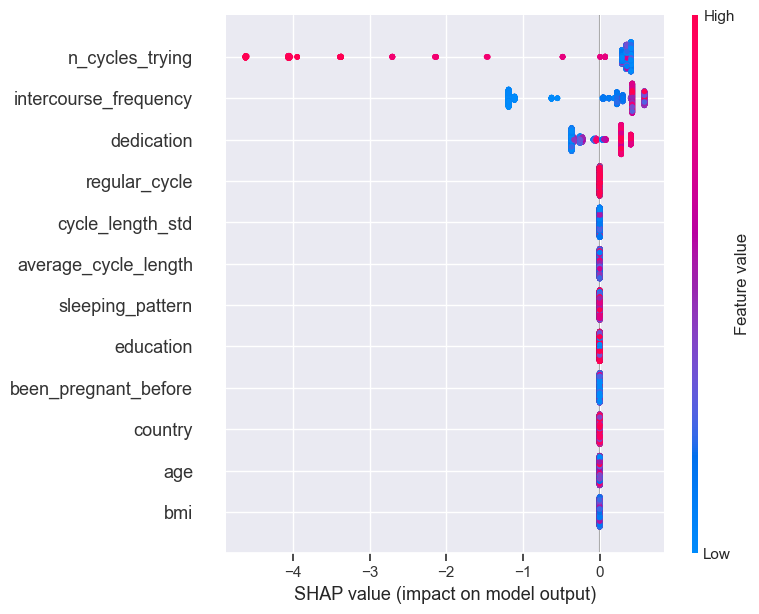

In [54]:
shap.summary_plot(shap_values, X)

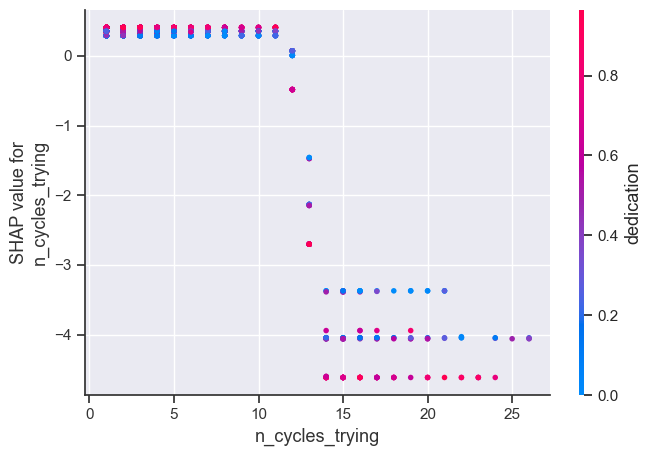

In [55]:
shap.dependence_plot("n_cycles_trying", shap_values, X)

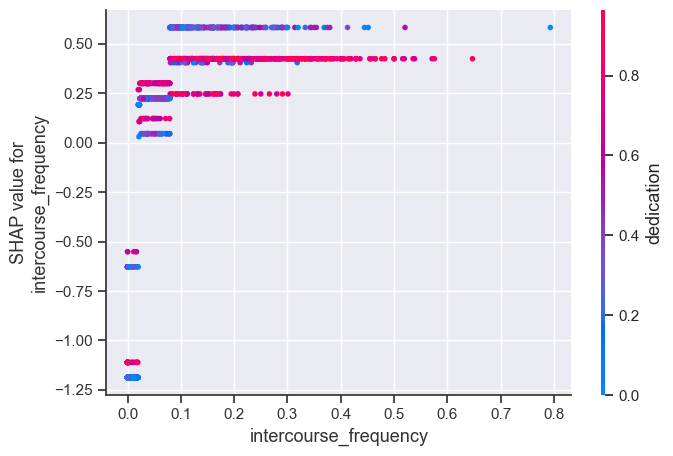

In [40]:
shap.dependence_plot("intercourse_frequency", shap_values, X)